# Notebook 13 - Autoencoders Convolucionales.

*   Recuerda que puedes consultar la documentación sobre una función escribiendo **?** justo después de la función: *Ejemplo: np.maximum?*
*   Puedes ejecutar el contenido de una celda con el atajo de teclado **CTRL+ENTER**
*   Utiliza **TAB** cada vez que quieras autocompletar una llamada a una función.
*   Puedes ejecutar instrucciones de bash directamente desde el notebook usando **!** : *Ejemplo: !pip install tensorflow*
*   Recuerda que Google es tu amigo, y saber buscar la información en las documentaciones de las librerías es muy importante.
*   Una solución correcta no es la que funciona sino la que se entiende!
*   No dudes en preguntar cualquier duda al profesor que lleva todo el día dando la turra.

## 1. De blanco y negro a color. 
---

1.   Estudia todas los comandos utilizados para cargar los archivos porque hay cosicas interesantes. ¿Para qué nos sirven? Inicialmente estaremos trabajando con las 10000 imágenes de la carpeta test para no tener problemas de rendimiento. Una vez tengamos el modelo construido, podremos utilizar mayores cantidades de datos.

2. Diseña con ***Keras*** tu propio autoencoder convolucional. En este caso tendrás que trabajar no solo con las capas ***tf.keras.Conv2D*** y ***tf.keras.MaxPooling2D*** que ya conocemos, sino también con la operación ***tf.keras.UpSampling2D*** que es la operación inversa a la de *MaxPooling2D* durante la fase de decodificación. Es una buena práctica ir anotando con comentarios cómo van variando las dimensiones de los tensores según van pasando cada capa, para tener así un mayor entendimiento de lo que ocurre. Si tu modelo funcionara correctamente, deberías de ser capaz de reconstruir las imágenes dada por entrada. Puedes probar incluso a enternarlo con ruido para ver si actua correctamente como *Denoiser Autoencoder*. Con eso, ya tienes mucho logrado. Puedes investigar el uso de técnicas como Batch Normalization para acelerar el proceso de entrenamiento. Igualmente, recomiendo investigar el uso de Checkpoints para ir guardando el estado de los pesos durante el entrenamiento.**Ojo!**  Si decides guardar archivos, recuerda que estos serán borrados cada vez que Google reinicie la máquina, así que conviene descargártelos en tu ordenador.

3. Investiga cómo utilizar el modelo que has implementado para resolver el problema de colorear imágenes en blanco y negro. Se espera en este punto que explotes las habilidades de investigar y buscar información que te pueda ayudar a resolver este problema. Usos de diferentes arquitecturas, tamaños de datos, técnicas de procesado, etc. son completamente válidas siempre y cuando entiendas y puedas justificar el por qué de las decisiones tomadas. ¡Esto ya es investigación real!



In [1]:
!wget -nc http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2019-01-01 22:20:52--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  66.4MB/s    in 4.3s    

2019-01-01 22:20:56 (55.4 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
!unzip -qq ./tiny-imagenet-200.zip

In [3]:
import numpy as np
import scipy as sc
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt

from matplotlib.pyplot        import imread
from tensorflow.keras.layers  import *

from os import listdir

path = "./tiny-imagenet-200/test/images/"

files = listdir(path)

imgs = np.zeros((len(files), 64, 64, 3))

for f in range(len(files)):
  img = plt.imread(path + files[f])
  # Evitamos cargar archivos que no tienen 3 canales de color.
  if (len(img.shape) == 3):
    imgs[f] = img / 255.

print(imgs.shape)

(10000, 64, 64, 3)


In [0]:
img_dim = imgs[0].shape

In [5]:
train_n = int(imgs.shape[0] * 0.8)
indices = np.random.permutation(imgs.shape[0])
training_idx, test_idx = indices[:train_n], indices[train_n:]
imgs_train, imgs_test = imgs[training_idx,:], imgs[test_idx,:]

print(imgs_train.shape, imgs_test.shape)

### COMIENZA TU CÓDIGO AQUÍ ###

(8000, 64, 64, 3) (2000, 64, 64, 3)


Vamos a ver un ejemplo del dataset

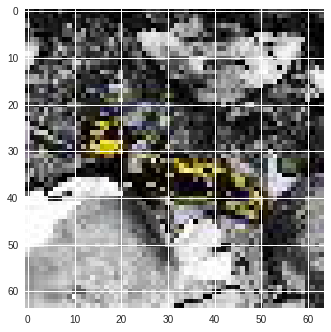

In [6]:
plt.imshow(imgs_train[0])

Importamos las librerías de RN

In [0]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import optimizers
import tensorflow as tf
import numpy as np

Esta es una versión de la arquitectura que luego mejoré

In [8]:
'''code_dim = 32 / (2*2*2)

input_image = Input(shape=img_dim, name='image_input')
x = Conv2D(filters=64, kernel_size=3, padding='same', strides=1, activation='relu')(input_image)
x = Conv2D(filters=64, kernel_size=3, padding='same', strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x) 
x = Conv2D(filters=32, kernel_size=3, padding='same', strides=1, activation='relu')(x)
x = Conv2D(filters=32, kernel_size=3, padding='same', strides=1, activation='relu')(x)
x = MaxPooling2D(2)(x) 


code = Conv2D(filters=16, kernel_size=3, padding='same', strides=1, activation='relu')(x)


input_code = Input(shape=(16, 16, 16), name='image_input')
y = Conv2D(filters=32, kernel_size=3, padding='same', strides=1, activation='relu')(input_code) 
y = Conv2D(filters=32, kernel_size=3, padding='same', strides=1, activation='relu')(y) 
y = BatchNormalization()(y)
y = UpSampling2D(2)(y)
y = Conv2D(filters=64, kernel_size=3, padding='same', strides=1, activation='relu')(y)
y = Conv2D(filters=64, kernel_size=3, padding='same', strides=1, activation='relu')(y)
y = UpSampling2D(2)(y)
result = Conv2D(filters=3, kernel_size=3, padding='same', strides=1, activation='sigmoid')(y)



encoder = Model(inputs=input_image, outputs=code, name='encoder')
decoder = Model(inputs=input_code, outputs=result, name='decoder')



input_encoder = Input(shape=img_dim, name='encoder_input')
autoencoder = Model(inputs=input_encoder, outputs=decoder(encoder(input_encoder)), name='autoencoder')'''

"code_dim = 32 / (2*2*2)\n\ninput_image = Input(shape=img_dim, name='image_input')\nx = Conv2D(filters=64, kernel_size=3, padding='same', strides=1, activation='relu')(input_image)\nx = Conv2D(filters=64, kernel_size=3, padding='same', strides=1, activation='relu')(x)\nx = BatchNormalization()(x)\nx = MaxPooling2D(2)(x) \nx = Conv2D(filters=32, kernel_size=3, padding='same', strides=1, activation='relu')(x)\nx = Conv2D(filters=32, kernel_size=3, padding='same', strides=1, activation='relu')(x)\nx = MaxPooling2D(2)(x) \n\n\ncode = Conv2D(filters=16, kernel_size=3, padding='same', strides=1, activation='relu')(x)\n\n\ninput_code = Input(shape=(16, 16, 16), name='image_input')\ny = Conv2D(filters=32, kernel_size=3, padding='same', strides=1, activation='relu')(input_code) \ny = Conv2D(filters=32, kernel_size=3, padding='same', strides=1, activation='relu')(y) \ny = BatchNormalization()(y)\ny = UpSampling2D(2)(y)\ny = Conv2D(filters=64, kernel_size=3, padding='same', strides=1, activation=

Esta es la arquitectura final que use

In [0]:
input_image = Input(shape=img_dim, name='image_input')
x = BatchNormalization()(input_image)
x = Conv2D(filters=32, kernel_size=5, padding='same', strides=1, activation='relu')(x)
x = Conv2D(filters=32, kernel_size=5, padding='same', strides=1, activation='relu')(x)
x = Conv2D(filters=64, kernel_size=5, padding='same', strides=1, activation='relu')(x)
x = MaxPooling2D(2)(x) 
x = Conv2D(filters=128, kernel_size=3, padding='same', strides=1, activation='relu')(x)
x = Conv2D(filters=128, kernel_size=3, padding='same', strides=2, activation='relu')(x)

code = Conv2D(filters=8, kernel_size=3, padding='same', strides=1, activation='relu')(x)


input_code = Input(shape=(16, 16, 8), name='image_input')
y = Conv2D(filters=128, kernel_size=3, padding='same', strides=1, activation='relu')(input_code)
y = UpSampling2D(2)(y)
y = Conv2D(filters=128, kernel_size=3, padding='same', strides=1, activation='relu')(y)
y = BatchNormalization()(y)
y = UpSampling2D(2)(y)
y = Conv2D(filters=64, kernel_size=3, padding='same', strides=1, activation='relu')(y)
y = Conv2D(filters=32, kernel_size=5, padding='same', strides=1, activation='relu')(y)
y = Conv2D(filters=32, kernel_size=5, padding='same', strides=1, activation='relu')(y)
result = Conv2D(filters=3, kernel_size=5, padding='same', strides=1, activation='sigmoid')(y)



encoder = Model(inputs=input_image, outputs=code, name='encoder')
decoder = Model(inputs=input_code, outputs=result, name='decoder')



input_encoder = Input(shape=img_dim, name='encoder_input')
autoencoder = Model(inputs=input_encoder, outputs=decoder(encoder(input_encoder)), name='autoencoder')

Después de probar con diferentes optimizadores me decante por el adadelta

In [20]:
sgd = optimizers.SGD(lr=0.02, decay=1e-6, momentum=0.95, nesterov=True)
adam = optimizers.Adam(lr=0.02)

autoencoder.compile(loss='binary_crossentropy',
                optimizer='adadelta',
                metrics=['mse', 'accuracy'])

# autoencoder.load_weights('./top_weights_image.h5') # descomentar para cargar pesos

mc = ModelCheckpoint(filepath='./top_weights_image.h5', monitor='val_mean_squared_error', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(monitor='val_mean_squared_error', patience=15, verbose=1)
# rlr = ReduceLROnPlateau(monitor='val_mean_squared_error')

callbacks = [mc, es]

history = autoencoder.fit(imgs_train, imgs_train, epochs=50, batch_size=128,
                    validation_data=(imgs_test, imgs_test), verbose=True,
                    callbacks=callbacks)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
7936/8000 [============================>.] - ETA: 0s - loss: 78.6476 - mean_squared_error: 0.0462 - acc: 0.0518
Epoch 00001: val_mean_squared_error improved from inf to 0.07086, saving model to ./top_weights_image.h5
8000/8000 [==============================] - 40s 5ms/step - loss: 78.3072 - mean_squared_error: 0.0460 - acc: 0.0517 - val_loss: 84.2494 - val_mean_squared_error: 0.0709 - val_acc: 0.0459
Epoch 2/50
7936/8000 [============================>.] - ETA: 0s - loss: 72.2051 - mean_squared_error: 0.0256 - acc: 0.0570
Epoch 00002: val_mean_squared_error improved from 0.07086 to 0.04721, saving model to ./top_weights_image.h5
8000/8000 [==============================] - 31s 4ms/step - loss: 71.9264 - mean_squared_error: 0.0256 - acc: 0.0569 - val_loss: 77.8012 - val_mean_squared_error: 0.0472 - val_acc: 0.0506
Epoch 3/50
7936/8000 [============================>.] - ETA: 0s - loss: 70.9308 - mean_squared_error: 0.0217 - acc: 

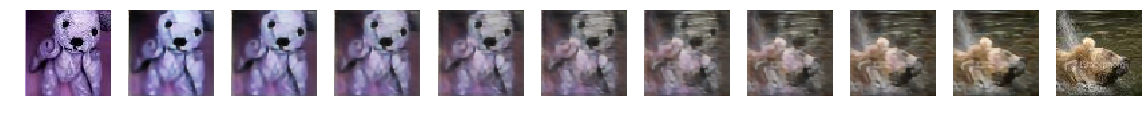

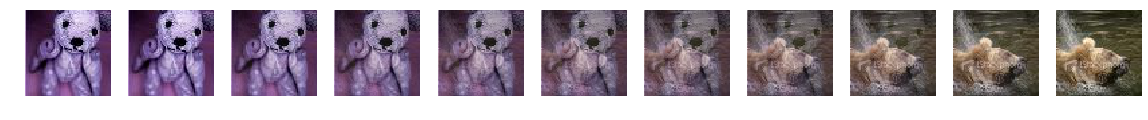

In [22]:
#@title Interpolaciones de imagenes
imagen_1 = 61 #@param {type:"number"}
imagen_2 = 21 #@param {type:"number"}
import matplotlib.pyplot as plt

images = np.array([imgs_test[imagen_1], imgs_test[imagen_2]])
codes = encoder.predict(images)

splits = 10

fig, axes = plt.subplots(1, splits + 1, figsize=(20,20))

axes[0].imshow(images[0])
axes[0].axis('off')

for i, p in enumerate(np.linspace(0,1,splits)):
  
  interpolation = (1 - p) * codes[0] + p * codes[1]
    
  pred = decoder.predict(np.array([interpolation]))[0]
  
  axes[i + 1].imshow(pred)
  axes[i + 1].axis('off')
  
  
axes[splits].imshow(images[1])
axes[splits].axis('off')

plt.show()

fig, axes = plt.subplots(1, splits + 1, figsize=(20,20))

axes[0].imshow(images[0])
axes[0].axis('off')

for i, p in enumerate(np.linspace(0,1,splits)):
  
  interpolation = (1 - p) * images[0] + p * images[1]
    
  axes[i + 1].imshow(interpolation)
  axes[i + 1].axis('off')
  
  
axes[splits].imshow(images[1])
axes[splits].axis('off')

plt.show()

La interpolación de imagenes usando RN es muy similar a una interpolación lineal, lo que la red se centra en almacenar patrones de la imagen y no que la imagen se vea realista como en el caso de las GAN. 
La interpolación con RN es la fila de arriba, la lineal la de abajo. Las imágenes primera y última son las reales que se van a interpolar.

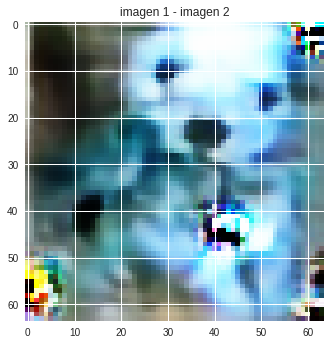

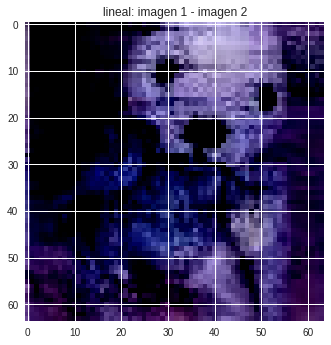

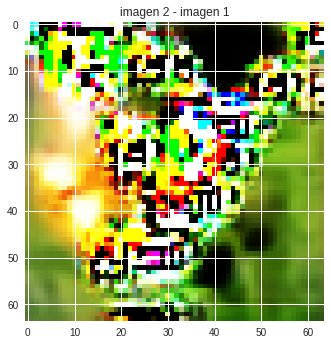

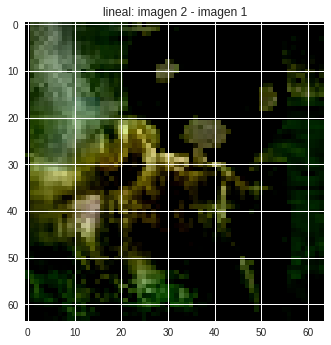

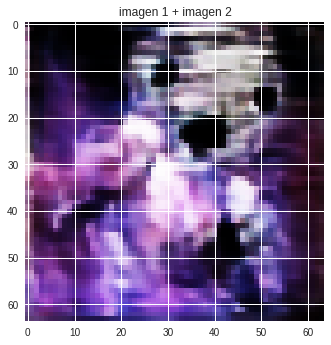

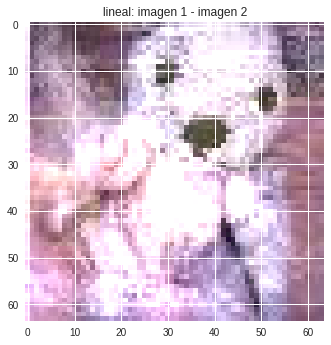

In [23]:
images = np.array([imgs_test[imagen_1], imgs_test[imagen_2]])
codes = encoder.predict(images)

pred = decoder.predict(np.expand_dims(codes[0] - codes[1], axis=0))[0]

plt.title('imagen 1 - imagen 2')
plt.imshow(np.clip(pred, 0, 1))
plt.show()

plt.title('lineal: imagen 1 - imagen 2')
plt.imshow(np.clip(images[0] - images[1], 0, 1))
plt.show()


pred = decoder.predict(np.expand_dims(codes[1] - codes[0], axis=0))[0]
plt.title('imagen 2 - imagen 1')
plt.imshow(np.clip(pred, 0, 1))
plt.show()

plt.title('lineal: imagen 2 - imagen 1')
plt.imshow(np.clip(images[1] - images[0], 0, 1))
plt.show()


pred = decoder.predict(np.expand_dims(codes[1] + codes[0], axis=0))[0]
plt.title('imagen 1 + imagen 2')
plt.imshow(np.clip(pred, 0, 1))
plt.show()

plt.title('lineal: imagen 1 - imagen 2')
plt.imshow(np.clip(images[1] + images[0], 0, 1))
plt.show()

Curiosamente las sumas de las imagenes no son iguales si se hacen con los espacios latentes, como si se podía ver en la interpolación. Puede que estas operaciones den resultados no muy parecidos a los ejemplos con los que ha entrenado la red y esta empiece a hacer cosas más raras, más aprecidas al siguiente ejemplo con valores aleatorios en el espacio latente.

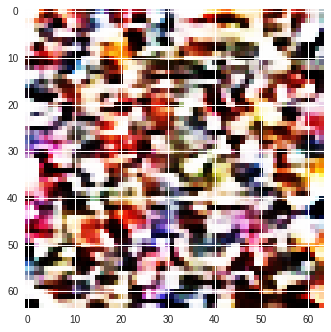

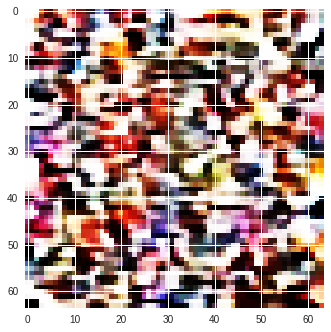

In [24]:
from sklearn.preprocessing import normalize

pred = decoder.predict(np.random.random(codes.shape) * codes.max())[0]
  
plt.imshow(np.clip(pred, 0, 1))
plt.show()

plt.imshow((pred - pred.min()) / pred.max())
plt.show()


Aquí se puede ver imagenes aleatorias generadas por la red. Como ya hemos visto, la red a conseguido abstraer determinados patrones básicos de las imagenes. Al decirle que genere uno aleatorio, nos mostrará todos estos patrones, generalmente bordes.

Otra cosa que la red ha entendido es que la salida debe de estar entre 0 - 1, por lo que aunque se reescale (los valores podrían salir entre 0.4 y 0.6, más de 1 no debería si la función es sigmoide), por lo que la imagen de arriba ( en valores originales) y la de abajo reescalada a 0 - 1, son bastante parecidas, por no decir identicas, pues los bordes suelen tener colores negros y blancos.

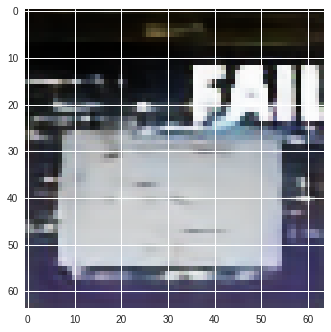

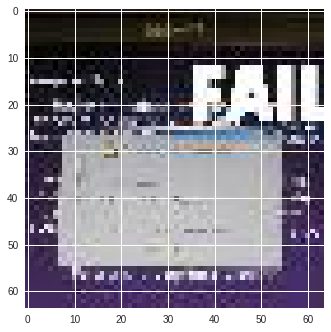

In [25]:
plt.imshow(autoencoder.predict(imgs_test[1].reshape(1, 64, 64, 3))[0])
plt.show()
plt.imshow(imgs_test[1])
plt.show()

Arriba la imagen comprimida después de su paso por el encoder, abajo la real.

In [26]:
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
__________

Y ahora vamos con el intento de pasar fotos de blanco y negro a color, usando practicamente la misma arquitectura, pero cambiando el numero de neuronas de entrada

In [0]:
def black_and_white_model():
  input_image = Input(shape=(64, 64, 1), name='image_input')
  x = BatchNormalization()(input_image)
  x = Conv2D(filters=32, kernel_size=5, padding='same', strides=1, activation='relu')(x)
  x = Conv2D(filters=32, kernel_size=5, padding='same', strides=1, activation='relu')(x)
  x = Conv2D(filters=64, kernel_size=5, padding='same', strides=1, activation='relu')(x)
  x = MaxPooling2D(2)(x) 
  x = Conv2D(filters=128, kernel_size=3, padding='same', strides=1, activation='relu')(x)
  x = Conv2D(filters=128, kernel_size=3, padding='same', strides=2, activation='relu')(x)

  code = Conv2D(filters=12, kernel_size=3, padding='same', strides=1, activation='relu')(x)


  input_code = Input(shape=(16, 16, 12), name='image_input')
  y = Conv2D(filters=128, kernel_size=3, padding='same', strides=1, activation='relu')(input_code)
  y = UpSampling2D(2)(y)
  y = Conv2D(filters=128, kernel_size=3, padding='same', strides=1, activation='relu')(y)
  y = BatchNormalization()(y)
  y = UpSampling2D(2)(y)
  y = Conv2D(filters=64, kernel_size=3, padding='same', strides=1, activation='relu')(y)
  y = Conv2D(filters=32, kernel_size=5, padding='same', strides=1, activation='relu')(y)
  y = Conv2D(filters=32, kernel_size=5, padding='same', strides=1, activation='relu')(y)
  result = Conv2D(filters=3, kernel_size=5, padding='same', strides=1, activation='sigmoid')(y)



  encoder = Model(inputs=input_image, outputs=code, name='encoder')
  decoder = Model(inputs=input_code, outputs=result, name='decoder')



  input_encoder = Input(shape=(64, 64, 1), name='encoder_input')
  autoencoder = Model(inputs=input_encoder, outputs=decoder(encoder(input_encoder)), name='autoencoder')
  
  return {'encoder': encoder, 'decoder': decoder, 'autoencoder': autoencoder}

blackoder = black_and_white_model()

A blanco y negro (y un intento a cymk, que al final no termine)

In [28]:
def to_black_and_white(imgs):
  return 1 - np.mean(imgs, axis=3, keepdims=True)

# plt.imshow( to_black_and_white( imgs_train ) [0].reshape(64,64) )

'''
def rgb_to_cmyk(img_arr):
    aaa = []

    img_arr_min = (1 - img_arr)
    K = np.min(img_arr_min, axis=2)

    C_init = (img_arr_min[:, :, 0])
    M_init = (img_arr_min[:, :, 1])
    Y_init = (img_arr_min[:, :, 2])

    C = C_init - K
    M = M_init - K
    Y = Y_init - K

    aaa.append(C)
    aaa.append(M)
    aaa.append(Y)
    aaa.append(K)
    new_arr = np.array(aaa).transpose(1,2,0)
    return new_arr
  
imgs_train_cymk = [rgb_to_cmyk( img ) for img in imgs_train[0:10] ]
plt.imshow( imgs_train_cymk [0] )'''

'\ndef rgb_to_cmyk(img_arr):\n    aaa = []\n\n    img_arr_min = (1 - img_arr)\n    K = np.min(img_arr_min, axis=2)\n\n    C_init = (img_arr_min[:, :, 0])\n    M_init = (img_arr_min[:, :, 1])\n    Y_init = (img_arr_min[:, :, 2])\n\n    C = C_init - K\n    M = M_init - K\n    Y = Y_init - K\n\n    aaa.append(C)\n    aaa.append(M)\n    aaa.append(Y)\n    aaa.append(K)\n    new_arr = np.array(aaa).transpose(1,2,0)\n    return new_arr\n  \nimgs_train_cymk = [rgb_to_cmyk( img ) for img in imgs_train[0:10] ]\nplt.imshow( imgs_train_cymk [0] )'

In [0]:
from tensorflow.image import yuv_to_rgb, rgb_to_yuv

blackoder['autoencoder'].compile(loss='binary_crossentropy',
                optimizer='adadelta',
                metrics=['mse', 'accuracy'])

# blackoder['autoencoder'].load_weights('./top_weights_black.h5')

mc2 = ModelCheckpoint(filepath='./top_weights_black.h5', monitor='val_mean_squared_error', save_best_only='True', save_weights_only='True', verbose=1)
# es2 = EarlyStopping(monitor='val_mean_squared_error', patience=15, verbose=1)
# rlr = ReduceLROnPlateau(monitor='val_mean_squared_error')

callbacks = [mc2]

imgs_train_black = to_black_and_white(imgs_train)
imgs_test_black = to_black_and_white(imgs_test)


In [30]:
history2 = blackoder['autoencoder'].fit(imgs_train_black, imgs_train, epochs=10, batch_size=128,
                    validation_data=(imgs_test_black, imgs_test), verbose=True,
                    callbacks=callbacks, steps_per_epoch=None)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
7936/8000 [============================>.] - ETA: 0s - loss: 78.4514 - mean_squared_error: 0.0441 - acc: 0.0518
Epoch 00001: val_mean_squared_error improved from inf to 0.07898, saving model to ./top_weights_black.h5
8000/8000 [==============================] - 33s 4ms/step - loss: 78.1272 - mean_squared_error: 0.0440 - acc: 0.0519 - val_loss: 86.3479 - val_mean_squared_error: 0.0790 - val_acc: 0.0418
Epoch 2/10
7936/8000 [============================>.] - ETA: 0s - loss: 72.2090 - mean_squared_error: 0.0255 - acc: 0.0569
Epoch 00002: val_mean_squared_error improved from 0.07898 to 0.05645, saving model to ./top_weights_black.h5
8000/8000 [==============================] - 31s 4ms/step - loss: 71.9213 - mean_squared_error: 0.0255 - acc: 0.0568 - val_loss: 80.3764 - val_mean_squared_error: 0.0564 - val_acc: 0.0473
Epoch 3/10
7936/8000 [============================>.] - ETA: 0s - loss: 70.9335 - mean_squared_error: 0.0220 - acc: 

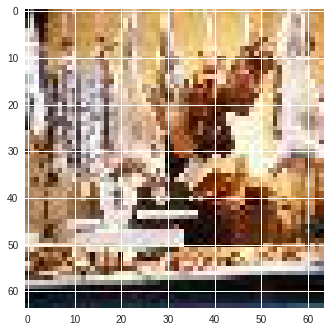

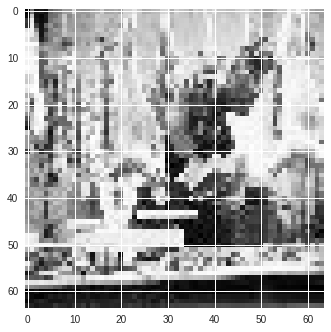

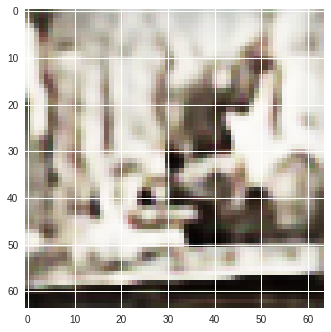

In [31]:
image = imgs_test[10]
image_black = to_black_and_white( [image] )
predicted = blackoder['autoencoder'].predict(image_black)
plt.imshow(image)
plt.show()
plt.imshow(image_black.reshape(64,64))
plt.show()
plt.imshow(np.clip(predicted.reshape(64,64,3), 0, 1))
plt.show()

Como puedes observar los resultados no son muy buenos, como usamos la arquitectura anterior, el funcionamiento será parecido.

Esta red detecta patrones pequeños, pero no alcanza a comprender que objetos son, por lo que no puede entender que eso gris de arriba puede ser un cielo que debe pintar de azul. En cambio si que cambia un poco de tonalidad en los bordes, que si alcanza a comprender.

Sin embargo, como no llega a saber que color es cada cosa, al final acaba cogiendo el color más común, el famoso sepia